In [0]:
import numpy as np
from numpy import random as npr
import matplotlib.pyplot as plt

# Probabilistic Graphical Models 1

Adrien DANEL

Guillaume DESFORGES

## Preliminaries : log-sum-exp trick

> **Question 0**:
>
> In many practical applications, we often need to compute $s = \log \sum_{i=1}^I \exp(v_i)$, where each $v_i < 0$ and $|v_i|$ is very large.
>
> Derive (mathematically) and implement a numerically stable algorithm for computing `log(sum(exp(v)))`, where $v = {v_i}_{i=1}^I$ is a vector of numbers.
>
> Explain why it should work.
>
> Test your algorithm on `log(sum(exp{-1234, -1235}))`.

The numerical computation of $f(v) = \log\left(\sum_{i=0}^{I}\exp(v_i)\right)$ with $v \in {\mathbb{R}_{-}}^I$ can be challenging as $v_i << 0$, because $\exp u \underset{u \to - \infty}{\to} 0$.

In [0]:
v = np.array([-1234, -1235])

In [0]:
# this fails
print(np.log(np.exp(v).sum()))

-inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


We propose an approximate formula to help compute $f(v)$ efficiently.

The $i$-th coordinate of the gradient of $f$ is :

$$\nabla f(v)_i = \frac{\exp(v_i)}{\sum_{j=1}^n\exp(v_j)}$$

Let $v^* = \underset{i \in [I]}{\max} v_i$ and $\mathbb{1}_I = (1)_{i \in [I]}$

Using Taylor's development we have

\begin{equation}
\begin{split}
f(v) & \simeq f(v - v^*\mathbb{1}_I) + <\nabla f(v - v^*\mathbb{1}_I), v - (v - v^*\mathbb{1}_I)>\\
     & \simeq f(v - v^*\mathbb{1}_I) + <\nabla f(v - v^*\mathbb{1}_I), v^*\mathbb{1}_I)>\\
     & \simeq v^* + f(v - v^*\mathbb{1}_I)\\
\end{split}
\end{equation}

Since on the highest coordinate $k^*$ of $v$ we have $\exp(v_{k^*} - v^*) = 1$, there is at least one term in the sum that is not 0. In addition, the translation from $v_i$ to $v_i - v^*$ can make some expressions be closer to 0 than just $v_i$, which means that it allows more terms of the sum to not go to 0 and makes a more accurate approximation than just $v_{k^*}$. This means that the method is numerically stable.

In [0]:
def log_sum_exp(v):
    v_max = max(v)
    return v_max + np.log(sum(np.exp(v - v_max)))

In [0]:
# this works !
print(log_sum_exp(v))

-1233.6867383124818


## Graphical Model : simulation and inference

> A robot is moving across a circular corridor. We assume that the possible positions of the robot is a discrete set with
> N locations. The initial position of the robot is unknown and assumed to be uniformly distributed. At each step k,
the robot stays where it is with probability , or moves to the next point in counter-clock direction with probability
> $1 − \epsilon$. At each step k, the robot can observe its true position with probability w. With probability 1 − w, the position
sensor fails and gives a measurement that is independent from the true position (uniformly distributed).

> **Question 1**:
>
> Choose the appropriate random variables, define their domains, write down the generative model and draw the associated directed graphical model.

We need three random variables for this problem


* $X_k$: true position of the robot at step $k$, defined on $\left[1; N\right]$
* $Y_k$: observed position of the robot at step $k$, defined on $\left[1; N\right]$
* $Z_k$: success of the sensor, defined on $\{0; 1\}$

The generative model is as follows :

$P(X_{1:n}, Y_{1:n}, Z_{1:n}) = P(X_1)\prod_{k=1}^{K}(P(X_k\mid X_{k-1})P(Z_k)P(Y_k \mid X_k, Z_k) $

The corresponding graph for such a model is the following (using Bishop's representation):
<center><img src="https://i.imgur.com/yTgVXyj.png" title="source: imgur.com" /></center/>

> **Question 2**:
>
> Define the conditional probability tables (i.e., the transition model and the observation model) given the verbal description above.

From our model, we get the following transition model:

* $\mathbb{P}(X_{k+1}= X_k \mid X_k) = \epsilon$
* $\mathbb{P}(X_{k+1}= \text{mod}(X_{k} + 1, N) \mid X_k) = 1-\epsilon$

We also get the following observation model:
* $\mathbb{P}(Y_k = X_k \mid X_k, Z_k = 1) = 1$
* $(Y_k \mid Z_k = 0) \sim \mathcal{U}(N)$

> **Question 3**:
>Specify the following verbal statements in terms of posterior quantities using mathematical notation.
>
> For example "*the distribution of the robot's location two time steps later given its current position at time k*" should be answered as $\mathbb{P}(x_{k+2} \mid x_k)$.

a. Distribution of the robot’s current position given the observations so far: $\mathbb{P}(x_k \mid y_1, ..., y_{k})$

b. Distribution of the robot’s current position given all the observations: $\mathbb{P}(x_k \mid y_1, ..., y_{n})$

c. Distribution of the robot’s next position given the observations so far: $\mathbb{P}(x_{k+1} \mid y_1, ..., y_{k})$

d. Distribution of the robot’s next sensor reading given the observations so far: $\mathbb{P}_{k+1} \mid y_1, ..., y_{k})$

e. Distribution of the robot’s initial position given observations so far: $\mathbb{P}(x_1 \mid y_1, ..., y_{k})$

f. Most likely current position of the robot given the observations so far: $\underset{X_k \in \mathbb{X}}{\text{argmax}}\ \mathbb{P}(X_k\mid y_1, ..., y_{k})$

g. Most likely trajectory taken by the robot from the start until now given the observations so far: $\underset{(X_1, ..., X_k)\in \mathbb{X}^k}{\text{argmax}}\ \mathbb{P}(X_{1},...,X_k \mid y_1, ..., y_{k})$





> **Question 4**:
>
> Implement a program that simulates this scenario; i.e., generates realizations from the movements of the robot and the associated sensor readings.
>
> Simulate a scenario for $n = 100$ with $N = 50$, $\epsilon= 0.3$, $\omega = 0.8$.

In [0]:
def generate_experiment(n, N, epsilon, w):
  x = [npr.randint(N)]
  y = [x[-1] if npr.rand() < w else npr.randint(N)]
  for k in range(n):
    x.append(x[-1] if npr.rand() < epsilon else (x[-1] + 1) % N)
    y.append(x[-1] if npr.rand() < w else npr.randint(N))
  
  return x, y

In [0]:
N = 50
epsilon = 0.3
w = 0.8
n = 100

x, y = generate_experiment(n, N, epsilon, w)

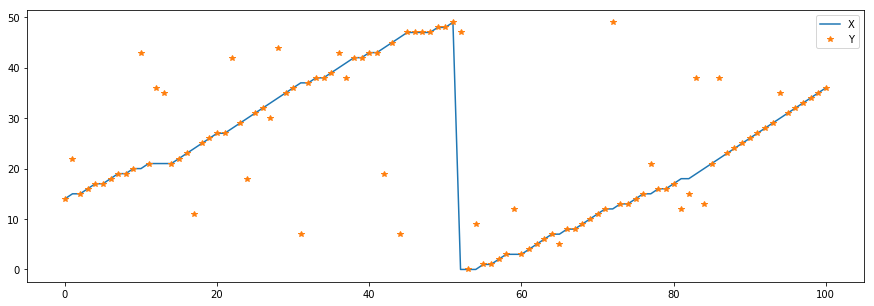

In [0]:
plt.subplots(figsize=(15, 5))
plt.plot(x, label="X")
plt.plot(y, '*', label="Y")
plt.legend()
plt.show()

> **Question 5**:
>
> Implement the Forward-Backward algorithm for computing the quantities defined in 3-a,b,f. (Attention: be careful with numerical stability! Modify the log-sum-exp trick for this algorithm)

In [0]:
# Transition matrix
transition_matrix = np.array([[epsilon if j == i else 1 - epsilon if j == (i - 1) % N else 0 for j in range(N)] for i in range(N)])

# Emission matrix
emission_matrix = np.array([[w if j == i else (1 - w)/(N - 1) for j in range(N)] for i in range(N)])

# Initial distribution
initial_distribution = np.ones(N) / N

In [0]:
def alphas_without_logsumexp_trick(y, transition_matrix, emission_matrix, initial_distribution):
    k = len(y)
    N = transition_matrix.shape[0]
    alphas = initial_distribution * emission_matrix[y[0]]
    for y_now in y[1:]:
        alphas = np.array([emission_matrix[y_now, x] * sum(transition_matrix[x, x_prev] * alphas[x_prev] for x_prev in range(N)) for x in range(N)])
    return alphas

In [0]:
def alphas_with_logsumexp_trick(y, transition_matrix, emission_matrix, initial_distribution):
    k = len(y)
    N = transition_matrix.shape[0]
    log_alphas = np.log(initial_distribution) + np.log(emission_matrix[y[0]])
    for y_now in y[1:]:
        log_alphas = np.array([log_sum_exp(np.array([np.log(emission_matrix[y_now, x]) + np.log(transition_matrix[x, x_prev]) + log_alphas[x_prev] for x_prev in range(N)])) for x in range(N)])
    return np.exp(log_alphas)

In [0]:
def compute_current_position_distribution_given_previous(y, transition_matrix, emission_matrix, initial_distribution, logsumexp_trick=False):
    alphas = alphas_with_logsumexp_trick if logsumexp_trick else alphas_without_logsumexp_trick
    p = alphas(y, transition_matrix, emission_matrix, initial_distribution)
    return p / sum(p)

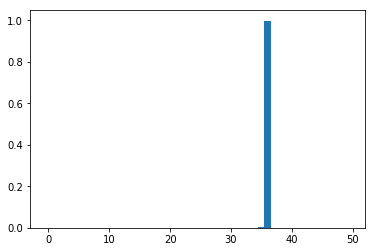

In [0]:
plt.hist(range(N), weights=compute_current_position_distribution_given_previous(y, transition_matrix, emission_matrix, initial_distribution), bins=np.arange(N+1)-0.5)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


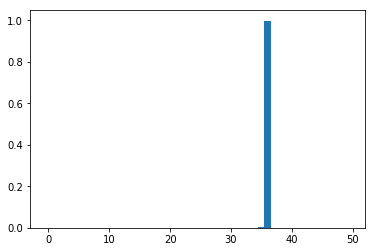

In [0]:
# with the log-sum-exp trick
plt.hist(range(N), weights=compute_current_position_distribution_given_previous(y, transition_matrix, emission_matrix, initial_distribution, logsumexp_trick=True), bins=np.arange(N+1)-0.5)
plt.show()

In [0]:
def compute_most_likely_position_given_previous(y, transition_matrix, emission_matrix, initial_distribution):
    return np.argmax(compute_current_position_distribution_given_previous(y, transition_matrix, emission_matrix, initial_distribution))

In [0]:
print(f"Most likely position given previous observations is {compute_most_likely_position_given_previous(y, transition_matrix, emission_matrix, initial_distribution)} when the real position is {x[-1]}")

Most likely position given previous observations is 36 when the real position is 36


In [0]:
def betas_without_logsumexp_trick(y, transition_matrix, emission_matrix, initial_distribution):
    n = len(y)
    N = transition_matrix.shape[0]
    betas = initial_distribution * emission_matrix[y[-1]]
    for y_now in reversed(y[:-1]):
        betas = np.array([emission_matrix[y_now, x] * sum(transition_matrix[x_next, x] * betas[x_next] for x_next in range(N)) for x in range(N)])
    return betas

In [0]:
def compute_trajectory_distribution(y, transition_matrix, emission_matrix, initial_distribution):
    n = len(y)
    N = transition_matrix.shape[0]
    x = []
    for k in range(n):
        alphas = alphas_without_logsumexp_trick(y[:k+1], transition_matrix, emission_matrix, initial_distribution)
        betas = betas_without_logsumexp_trick(y[k:], transition_matrix, emission_matrix, initial_distribution)
        p = alphas * betas
        x.append(np.argmax(p))
    return x

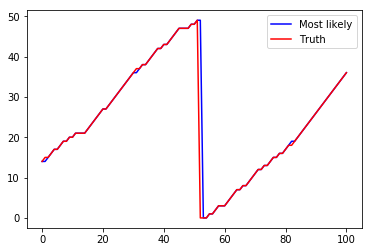

In [0]:
plt.plot(compute_trajectory_distribution(y, transition_matrix, emission_matrix, initial_distribution), 'b-', label='Most likely')
plt.plot(x, 'r-', label='Truth')
plt.legend()
plt.show()

> **Question 6**:
>
> Assume now that at each step the robot can be kidnapped with probability $\kappa$. If the robot is kidnapped its new position is independent from its previous position and is uniformly distributed.
>
> Repeat 4 and 5 for this new model with κ = 0.1. Can you reuse your code?

In [0]:
# Transition matrix
kappa = 0.05
transition_matrix_kidnap = np.array([[(1- kappa) * epsilon if j == i else (1 - kappa) * (1 - epsilon) if j == (i - 1) % N else kappa / N for j in range(N)] for i in range(N)])

In [0]:
def generate_experiment_with_kappa(n, N, epsilon, w):
  x = [npr.randint(N)]
  y = [x[-1] if npr.rand() < w else npr.randint(N)]
  for k in range(n):
    if npr.rand() < kappa:
        x.append(npr.randint(N))
    else:
        x.append(x[-1] if npr.rand() < epsilon else (x[-1] + 1) % N)
    y.append(x[-1] if npr.rand() < w else npr.randint(N))
  
  return x, y

In [0]:
x_with_kappa, y_with_kappa = generate_experiment_with_kappa(n, N, epsilon, w)

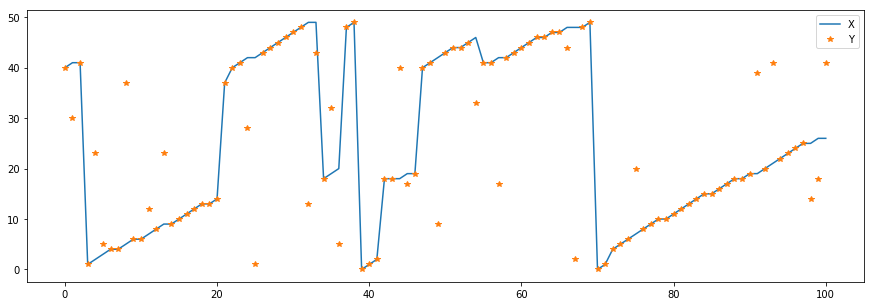

In [0]:
plt.subplots(figsize=(15, 5))
plt.plot(x_with_kappa, label="X")
plt.plot(y_with_kappa, '*', label="Y")
plt.legend()
plt.show()

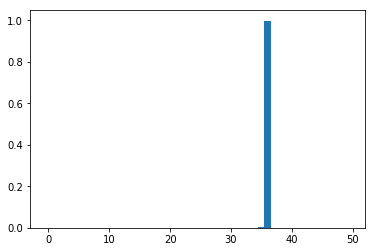

In [0]:
plt.hist(range(N), weights=compute_current_position_distribution_given_previous(y, transition_matrix_kidnap, emission_matrix, initial_distribution), bins=np.arange(N+1)-0.5)
plt.show()

In [0]:
print(f"Most likely position given previous observations is {compute_most_likely_position_given_previous(y, transition_matrix_kidnap, emission_matrix, initial_distribution)} when the real position is {x[-1]}")

Most likely position given previous observations is 36 when the real position is 36


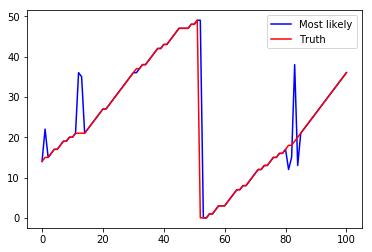

In [0]:
plt.plot(compute_trajectory_distribution(y, transition_matrix_kidnap, emission_matrix, initial_distribution), 'b-', label='Most likely')
plt.plot(x, 'r-', label='Truth')
plt.legend()
plt.show()